In [1]:
import sys
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python')
import time
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
#import fill_values as fv
#import calc_station_properties as cs

import createFolder as cF
from scipy.integrate import simps
import fcts_read_stat as rs


In [ ]:
http://thredds.met.no/thredds/dodsC/metusers/dagb/Franziska/mbr000/meps_2016122000.nc

In [4]:
thredds      = 'http://thredds.met.no/thredds/dodsC/metusers/dagb/Franziska/mbr000'

stn_name     = 'Haukeliseter'
stn_lat      = 59.8
stn_lon      = 7.2
#stn_name     = 'Stavanger'
#stn_lat      = 58.87
#stn_lon      = 5.67

#month        = 12
#day          = 24
forecasttime = '00'

In [5]:
fn = netCDF4.Dataset('%s/meps_2016122000.nc' %(thredds),'r')

In [6]:
fn

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: CF-1.6
    institution: Norwegian Meteorological Institute, MET Norway
    creator_url: met.no
    summary: MEPS (MetCoOp-Ensemble Prediction System) is a convection-permitting atmosphere ensemble model covering Scandinavia and the Nordic Seas. It has horizontal resolution of 2.5 km, has 65 vertical levels and 10 members. MEPS is ran four times daily (00,06,12,18) with three-hourly cycling for data assimilation. Member 0 and 1 are ran up to 66 hours, the rest up to 48 hours. Boundary data is from ECMWF, and initial perturbations are based on the SLAF method. Model code based on HARMONIE cy40h1.1
    source: MEPS 2.5km
    title: MEPS 2.5km
    min_time: 2016-12-20 00:00:00Z
    max_time: 2016-12-21
    geospatial_lat_min: 51.0
    geospatial_lat_max: 88.0
    geospatial_lon_min: -20.0
    geospatial_lon_max: 80.0
    references: unknown
    license: https://www.met.no/en/free-

In [11]:
## Latitudes
## [y = 949][x = 739]
latitude = fn.variables['latitude']

## Longitudes 
## [y = 949][x = 739]
longitude = fn.variables['longitude']

# Now find the absolute value of the difference between the  station's lat/lon with every point in the grid. 
x,y = rs.find_station_yx(latitude, longitude, stn_lat, stn_lon)
y = y[0]
x = x[0]

In [9]:
mass_fraction_of_snow_in_air_ml = fn.variables['mass_fraction_of_snow_in_air_ml']
mass_fraction_of_snow_in_air_ml

<class 'netCDF4._netCDF4.Variable'>
float32 mass_fraction_of_snow_in_air_ml(time, hybrid, y, x)
    _FillValue: 9.96921e+36
    long_name: Instantaneous snow in model levels
    standard_name: mass_fraction_of_snow_in_air
    units: kg/kg
    grid_mapping: projection_lambert
    coordinates: longitude latitude
    _ChunkSizes: [  1   1 949 889]
unlimited dimensions: time
current shape = (25, 65, 949, 889)
filling off

In [20]:
memb = np.arange(0,1)

In [46]:
######## with Vertical Levels ( hybrid )#################################
## hybrid levels atmosphere_hybrid_sigma_pressure_coordinate
# formula: p(n,k,j,i) = ap(k) + b(k)*ps(n,j,i)
# positive: down


### variables to calculate pressure
#p0 = fn.variables['p0']    ## p0: p0
ap = fn.variables['ap']    ## ap: ap
b = fn.variables['b']      ## b: b

surface_air_pressure = fn.variables['surface_air_pressure']
air_temperature_0m   = fn.variables['air_temperature_0m']
air_temperature_ml   = fn.variables['air_temperature_ml']

In [47]:
def mask_array(variable, #ens_memb, 
               y, x, EM):
    if EM == 10:
        if np.ma.is_masked(variable[:,:,:,#ens_memb,
                                    y,x]):
            mask = np.ma.getmaskarray(variable[:,:,:,#ens_memb,
                                               y,x])  
            fill_value = np.nan
            marr = np.ma.array(variable[:,:,:,#ens_memb,
                                        y,x], mask = mask, fill_value = fill_value)
            dtype = marr.filled().dtype
            filled = marr.filled()
        else:
            fill_value = np.nan
            marr = variable[:,:,:,#ens_memb,
                        y,x]
            filled = marr
            dtype = marr.dtype
    elif EM == 1:
        if np.ma.is_masked(variable[:,:,y,x]):
            mask = np.ma.getmaskarray(variable[:,:,y,x])  
            fill_value = np.nan
            marr = np.ma.array(variable[:,:,y,x], mask = mask, fill_value = fill_value)
            dtype = marr.filled().dtype
            filled = marr.filled()
        else:
            fill_value = np.nan
            marr = variable[:,:,y,x]
            filled = marr
            dtype = marr.dtype
    return(filled, dtype)

In [49]:
### mask arrays
surface_air_pressure, dtype_sap  = mask_array(surface_air_pressure, #ens_memb, 
                                                  y, x,EM=1)
air_temperature_0m,   dtype_at0m = mask_array(air_temperature_0m,   #ens_memb, 
                                                  y, x,EM=1)
air_temperature_ml,   dtype_atml = mask_array(air_temperature_ml,   #ens_memb, 
                                                  y, x,EM=1)

In [52]:
surface_air_pressure.shape

(25, 1)

In [58]:
def get_value_at_station(fn, variable, y, x):
    variable = fn.variables[variable]
    variable, dtype = mask_array(variable,y,x,EM=1)
    variable = np.fliplr(variable)
    variable = np.ma.masked_where(np.isnan(variable), variable)
    return(variable)

In [53]:
for ens_memb in memb:
### Transfer pressure coordinate
    p_interface = ap[:]+b[:]*surface_air_pressure[:,:]

### 1) Connect interface values and surface values for pressure
### Pressure
    p_interfaces2 = np.concatenate((p_interface[:,:],surface_air_pressure[:,:]),axis=1)

# transform hybrid sigma pressure coordinates at interface levels to pressure at model levels
    p_ml = np.empty([p_interfaces2.shape[0],p_interfaces2.shape[1]-1])
    for i in range(0,p_interfaces2.shape[1]-1):
        p_ml[:,i] = 1/2 * (p_interfaces2[:,i] + p_interfaces2[:,i+1])
    p_ml = np.concatenate((p_ml[:,:],surface_air_pressure[:,:]),axis=1)
    
### --> Now the pressure is calculated at each model level

### 2) Connect model levels and surface values for temperature
### Temperature
    temperature_ml = np.concatenate((air_temperature_ml[:air_temperature_ml.shape[0],:],
                                        air_temperature_0m[:air_temperature_ml.shape[0],:]),axis=1)

    

    dz, dgeop = rs.get_thickness(p_ml, temperature_ml)

    if ens_memb == 0:
        pressure_in_modellev = p_ml[:,0:-1]
        thickness_m   = dz
        thickness_phi = dgeop  
    else:
        pressure_in_modellev = np.dstack((pressure_in_modellev,p_ml[:,0:5]))
        thickness_m   = np.dstack((thickness_m,dz))
        thickness_phi = np.dstack((thickness_phi,dgeop))

pressure_in_modellev = np.ma.array(pressure_in_modellev,mask=np.ma.is_masked(pressure_in_modellev), 
                                       fill_value = np.nan)
thickness_m = np.ma.array(thickness_m,mask=np.ma.is_masked(thickness_m), 
                                       fill_value = np.nan)
thickness_phi = np.ma.array(thickness_phi,mask=np.ma.is_masked(thickness_phi), 
                                       fill_value = np.nan)

In [121]:
# Read in all values needed to present the microphysics
## Time
time_arr = fn.variables['time']
#ensemble_member_arr = fn.variables['ensemble_member']

## heights
height_above_msl_arr = fn.variables['height_above_msl']
height0_arr = fn.variables['height0']
height1_arr = fn.variables['height1']
height3_arr = fn.variables['height3']
hybrid_arr = fn.variables['hybrid']





######## with Vertical Levels ( height0 ) #################################
liquid_water_content_of_surface_snow = get_value_at_station(fn, 'liquid_water_content_of_surface_snow',y,x)
air_temperature_0m                   = get_value_at_station(fn, 'air_temperature_0m', y,x)
rainfall_amount                      = get_value_at_station(fn, 'rainfall_amount',y,x)
snowfall_amount                      = get_value_at_station(fn, 'snowfall_amount',y,x)
graupelfall_amount                   = get_value_at_station(fn, 'graupelfall_amount', y,x)
surface_air_pressure                 = get_value_at_station(fn, 'surface_air_pressure',y,x)
surface_geopotential                 = get_value_at_station(fn, 'surface_geopotential',y,x)
precipitation_amount_acc             = get_value_at_station(fn, 'precipitation_amount_acc',y,x)
int_rainfall_amount_wrt_time         = get_value_at_station(fn, 'integral_of_rainfall_amount_wrt_time',y,x)
int_snowfall_amount_wrt_time         = get_value_at_station(fn, 'integral_of_snowfall_amount_wrt_time',y,x)
int_graupelfall_amount_wrt_time      = get_value_at_station(fn, 'integral_of_graupelfall_amount_wrt_time',y,x)        
        
######## with Vertical Levels ( height1 )#################################
air_temperature_2m   = get_value_at_station(fn,'air_temperature_2m',y,x)
relative_humidity_2m = get_value_at_station(fn,'relative_humidity_2m',y,x)   
specific_humidity_2m = get_value_at_station(fn,'specific_humidity_2m',y,x) 

######## with Vertical Levels ( height3 )#################################
x_wind_10m = get_value_at_station(fn,'x_wind_10m',y,x)
y_wind_10m = get_value_at_station(fn,'y_wind_10m',y,x)

######## with Vertical Levels ( height_above_msl )#################################
air_pressure_at_sea_level = get_value_at_station(fn,'air_pressure_at_sea_level',y,x)

######## with Vertical Levels ( hybrid )#################################
## hybrid levels atmosphere_hybrid_sigma_pressure_coordinate
# formula: p(n,k,j,i) = ap(k) + b(k)*ps(n,j,i)
# positive: down

## values in fn file
specific_humidity_ml     = get_value_at_station(fn,'specific_humidity_ml',y,x)
cloud_condensed_water_ml = get_value_at_station(fn,'mass_fraction_of_cloud_condensed_water_in_air_ml',y,x)
cloud_ice_ml             = get_value_at_station(fn,'mass_fraction_of_cloud_ice_in_air_ml',y,x)
snow_ml                  = get_value_at_station(fn,'mass_fraction_of_snow_in_air_ml',y,x)
rain_ml                  = get_value_at_station(fn,'mass_fraction_of_rain_in_air_ml',y,x)
graupel_ml               = get_value_at_station(fn,'mass_fraction_of_graupel_in_air_ml',y,x)
pressure_departure       = get_value_at_station(fn,'pressure_departure',y,x)
air_temperature_ml       = get_value_at_station(fn,'air_temperature_ml',y,x)
x_wind_ml                = get_value_at_station(fn,'x_wind_ml',y,x)
y_wind_ml                = get_value_at_station(fn,'y_wind_ml',y,x)



In [122]:
# calculate density at each level
density_ml = pressure_in_modellev/(Rd*air_temperature_ml)

# convert from [kg/kg] to [kg/m^3]
cloud_condensed_water_ml = (cloud_condensed_water_ml*density_ml)
cloud_ice_ml = (cloud_ice_ml*density_ml)
snow_ml = (snow_ml*density_ml)
rain_ml = (rain_ml*density_ml)
graupel_ml = (graupel_ml*density_ml)


# convert the snow amount from [kg/m^2] into [g/m^2] by multiply with 1000
cloud_condensed_water_ml = (cloud_condensed_water_ml*1000.)
cloud_ice_ml = (cloud_ice_ml*1000.)
snow_ml = (snow_ml*1000.)
rain_ml = (rain_ml*1000.)
graupel_ml = (graupel_ml*1000)

# get ice amount (snow+graupel+cloud_ice)
ice_amount_ml = snow_ml + graupel_ml + cloud_ice_ml

# get liquid amount (rain+cloud_water)
water_amount_ml = rain_ml+cloud_condensed_water_ml

In [123]:
####
# create 2d time array
time_arr = np.repeat(time_arr, pressure_in_modellev.shape[1], axis = 0)
time_arr = np.reshape(time_arr, (-1, pressure_in_modellev.shape[1]))

In [124]:
# layer thickness to calculate height
thickness_ml     = thickness_m
h_above = []
h_above.append(np.zeros(thickness_ml[:,:].shape[0]))
th_arr = np.nansum([np.asarray(h_above)[:,0], thickness_ml[:,0]], axis = 0)
h_above.append(th_arr)
for i in range(2,thickness_ml[:,:].shape[1]):
    th_arr = np.nansum([h_above[i-1], thickness_ml[:,i-1]], axis = 0)
    h_above.append(th_arr)
height_ml = np.transpose(h_above) 

In [125]:
np.max(ice_amount_ml)

0.006904748009464034

In [126]:
np.max(water_amount_ml)

0.06156031650008874

In [127]:
np.max(rain_ml)

0.0009404053496394683

In [128]:
np.max(cloud_condensed_water_ml)

0.061542425714892386

In [129]:
year = 2016
month = 12
ini_day = 20

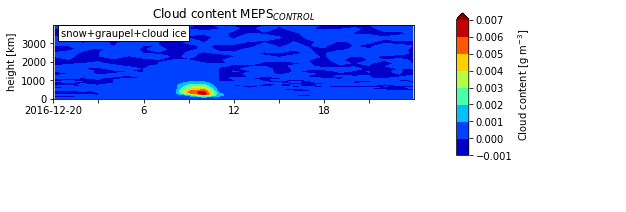

In [139]:
cc = 'snow+graupel+cloud ice'
plt_cloud_content(time_arr,height_ml,ice_amount_ml,cc)

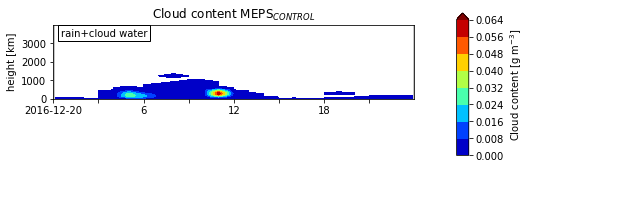

In [140]:
cc = 'rain+cloud water'
plt_cloud_content(time_arr,height_ml,water_amount_ml,cc)

In [79]:
from matplotlib.gridspec import GridSpec

In [138]:
def plt_cloud_content(time_arr,height_ml,cloud_content_ml,cc):
    
    ##### define things which are set for all #####
    champ = 255.
    vert_col = np.array([197,197,197])/champ    # vertical line for day marker

    
    #var_label = 'SWC [g m$^{-3}$]'
    var_label = 'Cloud content [g m$^{-3}$]'
    label_txt = 'height [km]'

    xmax = 24.
    ymax = 12500.

    xdays = ['%s-%s-%s' %(year,month,ini_day), '', 
        6, '',12, '', 18, '',
        '%s-%s-%s' %(year,month,ini_day+1),  '',
        6, '', 12, '', 18, '',
        '%s-%s-%s' %(year,month,ini_day+2)]
    
#    yticks3 = np.arange(0,14000.,2000)
 #   yticks = yticks3
    yticks3 = np.arange(0,4000.,1000)
    yticks = yticks3
    
    
    
    #levels = np.arange(0,1.51,0.01)
    levels = np.arange(0.,0.1,0.001)
    levels = np.arange(0., np.nanmax(cloud_content_ml),0.0001)

    #cb_ticks = []
    cb_ticks = levels[::30]
    
    
#    if np.max(cloud_content_ml) < 0.0001:
 #       print('cloud content < 0.001')
  #      return
   # else:
        
        
    ##### begin figure #####
    fig =plt.figure(figsize=(10,3))

    gs = GridSpec(2,3)
    ax0 = plt.subplot(gs[0,:-1])
    im0 = ax0.contourf(time_arr,height_ml,cloud_content_ml,#levels, 
            cmap='jet', extend = 'max', alpha = 1.0, 
       #    vmin = 0, vmax = 0.3, 
            origin = 'lower')
    #ax0.axis([time_arr[0,0], time_arr[-1,0], 0., ymax])
    ax0.axis([time_arr[0,0], time_arr[-1,0], 0., 4000])
    ax0.set_xticks( np.arange(time_arr[0,0],time_arr[-1,0],3*60*60))
    #ax0.get_xaxis().set_tick_params(width=5)
    ax0.set_xticklabels(xdays)

    ax0.set_yticks(yticks)
    ax0.set_ylabel(label_txt)#, fontsize = label_fs-2)

#ax.xaxis.grid()
# Vertical line to show end of day
    ax0.axvline(time_arr[0,0],color = vert_col, linewidth = 3)
    ax0.axvline(time_arr[24,0],color = vert_col, linewidth = 3)
    ax0.axvline(time_arr[-1,0],color = vert_col, linewidth = 3)


    ax31 = plt.subplot(gs[1,-1])
    ax31.axis('off')
    cbaxes = fig.add_axes([0.685, .275, 0.017, 0.66])  # [left, bottom, width, height] 
    cbar = fig.colorbar(im0, cax=cbaxes, #ticks = cb_ticks, 
                    orientation = 'vertical')#, pad=0.20, fraction = 0.08, shrink = 2.5)
    cbar.ax.tick_params()#labelsize= tick_fs-2)
    cbar.ax.set_ylabel(var_label)#,fontsize = label_fs-2)

    

    ax0.set_title('Cloud content MEPS$_{CONTROL}$')
    
    
    ax0.text(0.02,0.95, #'SWC$_{Retrieval\,\,3h}$' ,
                 cc ,
            verticalalignment ='top', horizontalalignment='left',
             transform = ax0.transAxes,
             color = 'k', #ontsize = im.fontsize,
             bbox={'facecolor':'white','alpha':1.,'pad':3})
    
#    lgd = plt.tight_layout(pad=1.4, w_pad=1.5, h_pad=1.5)
 #   return(lgd)